# Fruit Quality Spectral Data: Cleaning & Exploration
This notebook will:
1. Load the raw CSV spectra.  
2. Clean (drop NA, remove outliers).  
3. Smooth the spectra.  
4. Visualize raw vs. smoothed.  
5. Compute correlations and distributions.  
6. Sample wavelengths for a pairplot against the target.

In [8]:
# Cell 1: Imports & Config
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split

# plotting style
sns.set(style="whitegrid")
%matplotlib inline

# Path & target (update if needed)
DATA_PATH = "Assignment_DataScientist_20250502.csv"
TARGET_COLUMN = "Brix"


## Cell 2: Load & Inspect Raw Data


In [2]:
df = pd.read_csv(DATA_PATH)
print("Raw shape:", df.shape)
df.head()


Raw shape: (4876, 122)


,0.25_GHz_real,0.5_GHz_real,0.75_GHz_real,1.0_GHz_real,1.25_GHz_real,1.5_GHz_real,1.75_GHz_real,2.0_GHz_real,2.25_GHz_real,2.5_GHz_real,...,sensorT,TestDate,Experiment,Cultivar,Fruit nr,Size,Weight,Brix,TA,Firmness (kg)
0,0.928321,0.799110,0.607104,0.430211,0.171274,-0.056632,-0.274899,-0.489029,-0.670751,-0.796667,...,54.346122,18/01/2024,1,Cult1,1,3.503926,303,14.0,0.7073,8.391452
1,0.928362,0.795095,0.603138,0.428903,0.171034,-0.059646,-0.285999,-0.501920,-0.681401,-0.802221,...,54.233890,18/01/2024,1,Cult1,1,3.503926,303,14.0,0.7073,8.041279
2,0.920793,0.725661,0.539412,0.415448,0.164646,-0.104585,-0.367430,-0.560130,-0.722270,-0.831610,...,54.128772,18/01/2024,1,Cult1,2,2.992117,184,13.4,0.7651,8.201397
3,0.929618,0.756798,0.573948,0.448641,0.212831,-0.047378,-0.304099,-0.503503,-0.677524,-0.808135,...,54.123407,18/01/2024,1,Cult1,2,2.992117,184,13.4,0.7651,8.771562
4,0.924183,0.735891,0.556284,0.417789,0.169946,-0.098664,-0.358264,-0.553657,-0.715784,-0.827924,...,54.094455,18/01/2024,1,Cult1,3,3.011802,171,12.8,0.6108,7.321428


## Cell 3: Identify & Plot Outliers via z-score
Compute the maximum absolute z-score per sample across all numeric features and plot its distribution.


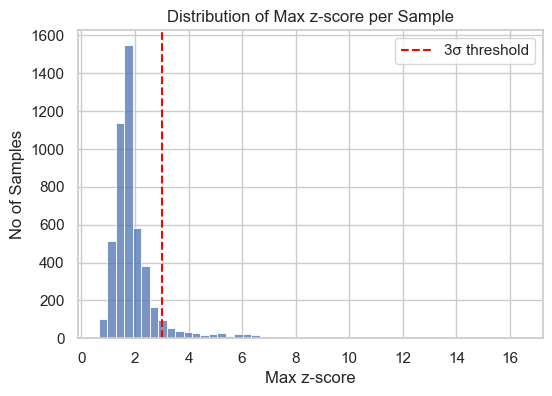

Outliers (max |z| > 3): 395 / 4876 samples


In [6]:
# Cell 3 code
#  –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Compute z-scores for every numeric column
numeric = df.select_dtypes(include=[np.number])
z_scores = (numeric - numeric.mean()) / numeric.std()

# Maximum absolute z-score per sample (row)
max_z = z_scores.abs().max(axis=1)

# Plot histogram of max |z-score|
plt.figure(figsize=(6,4))
sns.histplot(max_z, bins=50, kde=False)
plt.axvline(3, color='red', linestyle='--', label='3σ threshold')
plt.title('Distribution of Max z-score per Sample')
plt.xlabel('Max z-score')
plt.ylabel('No of Samples')
plt.legend()
plt.show()

# Print how many samples exceed the threshold
outlier_mask = max_z > 3
print(f"Outliers (max |z| > 3): {outlier_mask.sum()} / {len(df)} samples")


## Cell 4: Clean Data by Removing Outliers
Drop any row where max |z-score| > 3, then proceed with smoothing & EDA.


In [4]:
# Cell 4 code
#  –––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––
# Create cleaned DataFrame
df_clean = df.loc[~outlier_mask].reset_index(drop=True)
print("Shape before cleaning:", df.shape)
print("Shape after removing outliers:", df_clean.shape)

# (Optional) Verify no remaining extreme values
numeric_clean = df_clean.select_dtypes(include=[np.number])
max_z_clean = ((numeric_clean - numeric_clean.mean())/numeric_clean.std()).abs().max(axis=1)
print("Max |z| after cleaning:", max_z_clean.max().round(2))


Shape before cleaning: (4876, 122)
Shape after removing outliers: (4481, 122)
Max |z| after cleaning: 14.24


## Cell 4: Identify Spectral & Target Arrays
We know the first 112 columns are spectra (real+imag). Everything else is metadata or targets.



In [9]:
spec_cols = df_clean.columns[:112]
X = df_clean[spec_cols].values
y = df_clean[TARGET_COLUMN].values
print(f"Spectra shape: {X.shape}, Target shape: {y.shape}")


Spectra shape: (4481, 112), Target shape: (4481,)


## Cell 5: Smooth Spectra with Savitzky–Golay


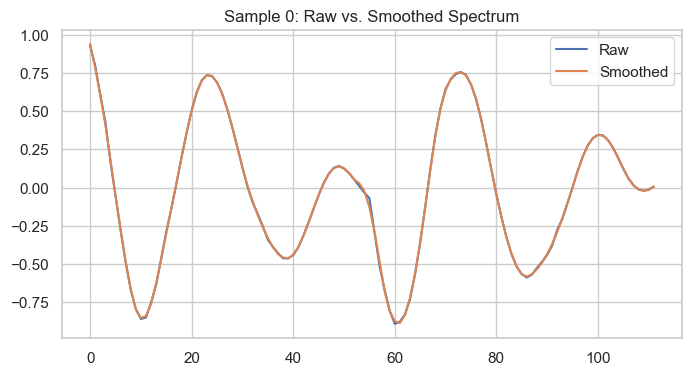

In [10]:
# apply smoothing along each row
X_smooth = savgol_filter(X, window_length=7, polyorder=2, axis=1)

# Plot raw vs. smoothed for the first sample
plt.figure(figsize=(8,4))
plt.plot(X[0], label="Raw")
plt.plot(X_smooth[0], label="Smoothed")
plt.title("Sample 0: Raw vs. Smoothed Spectrum")
plt.legend()
plt.show()


## Cell 6: Plot Several Smoothed Spectra


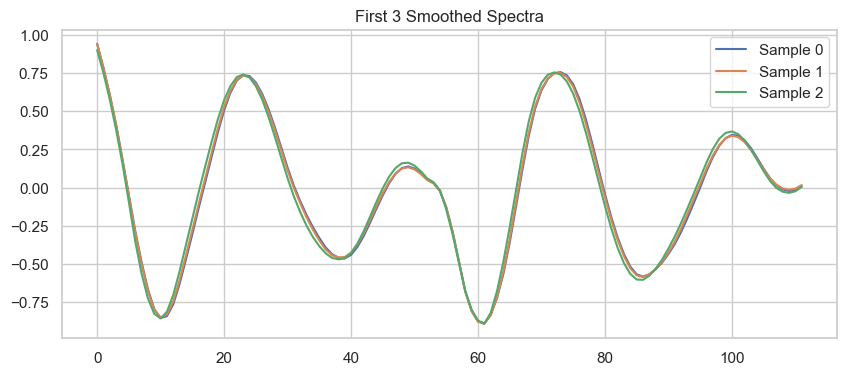

In [11]:
plt.figure(figsize=(10,4))
for i in range(3):
    plt.plot(X_smooth[i], label=f"Sample {i}")
plt.title("First 3 Smoothed Spectra")
plt.legend()
plt.show()


## Cell 7: Correlation of Mean Intensity & Target


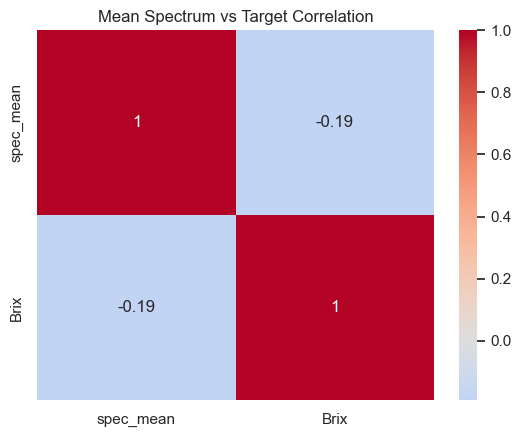

In [12]:
df_clean["spec_mean"] = X_smooth.mean(axis=1)
corr = df_clean[["spec_mean", TARGET_COLUMN]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Mean Spectrum vs Target Correlation")
plt.show()


## Cell 8: Target Distribution


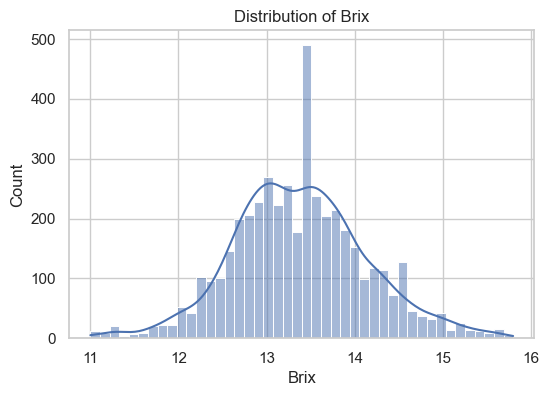

In [13]:
plt.figure(figsize=(6,4))
sns.histplot(df_clean[TARGET_COLUMN], kde=True)
plt.title(f"Distribution of {TARGET_COLUMN}")
plt.xlabel(TARGET_COLUMN)
plt.show()


## Cell 9: Pairplot of Selected Wavelengths vs Target
Sampling every 20th wavelength to keep plot readable.


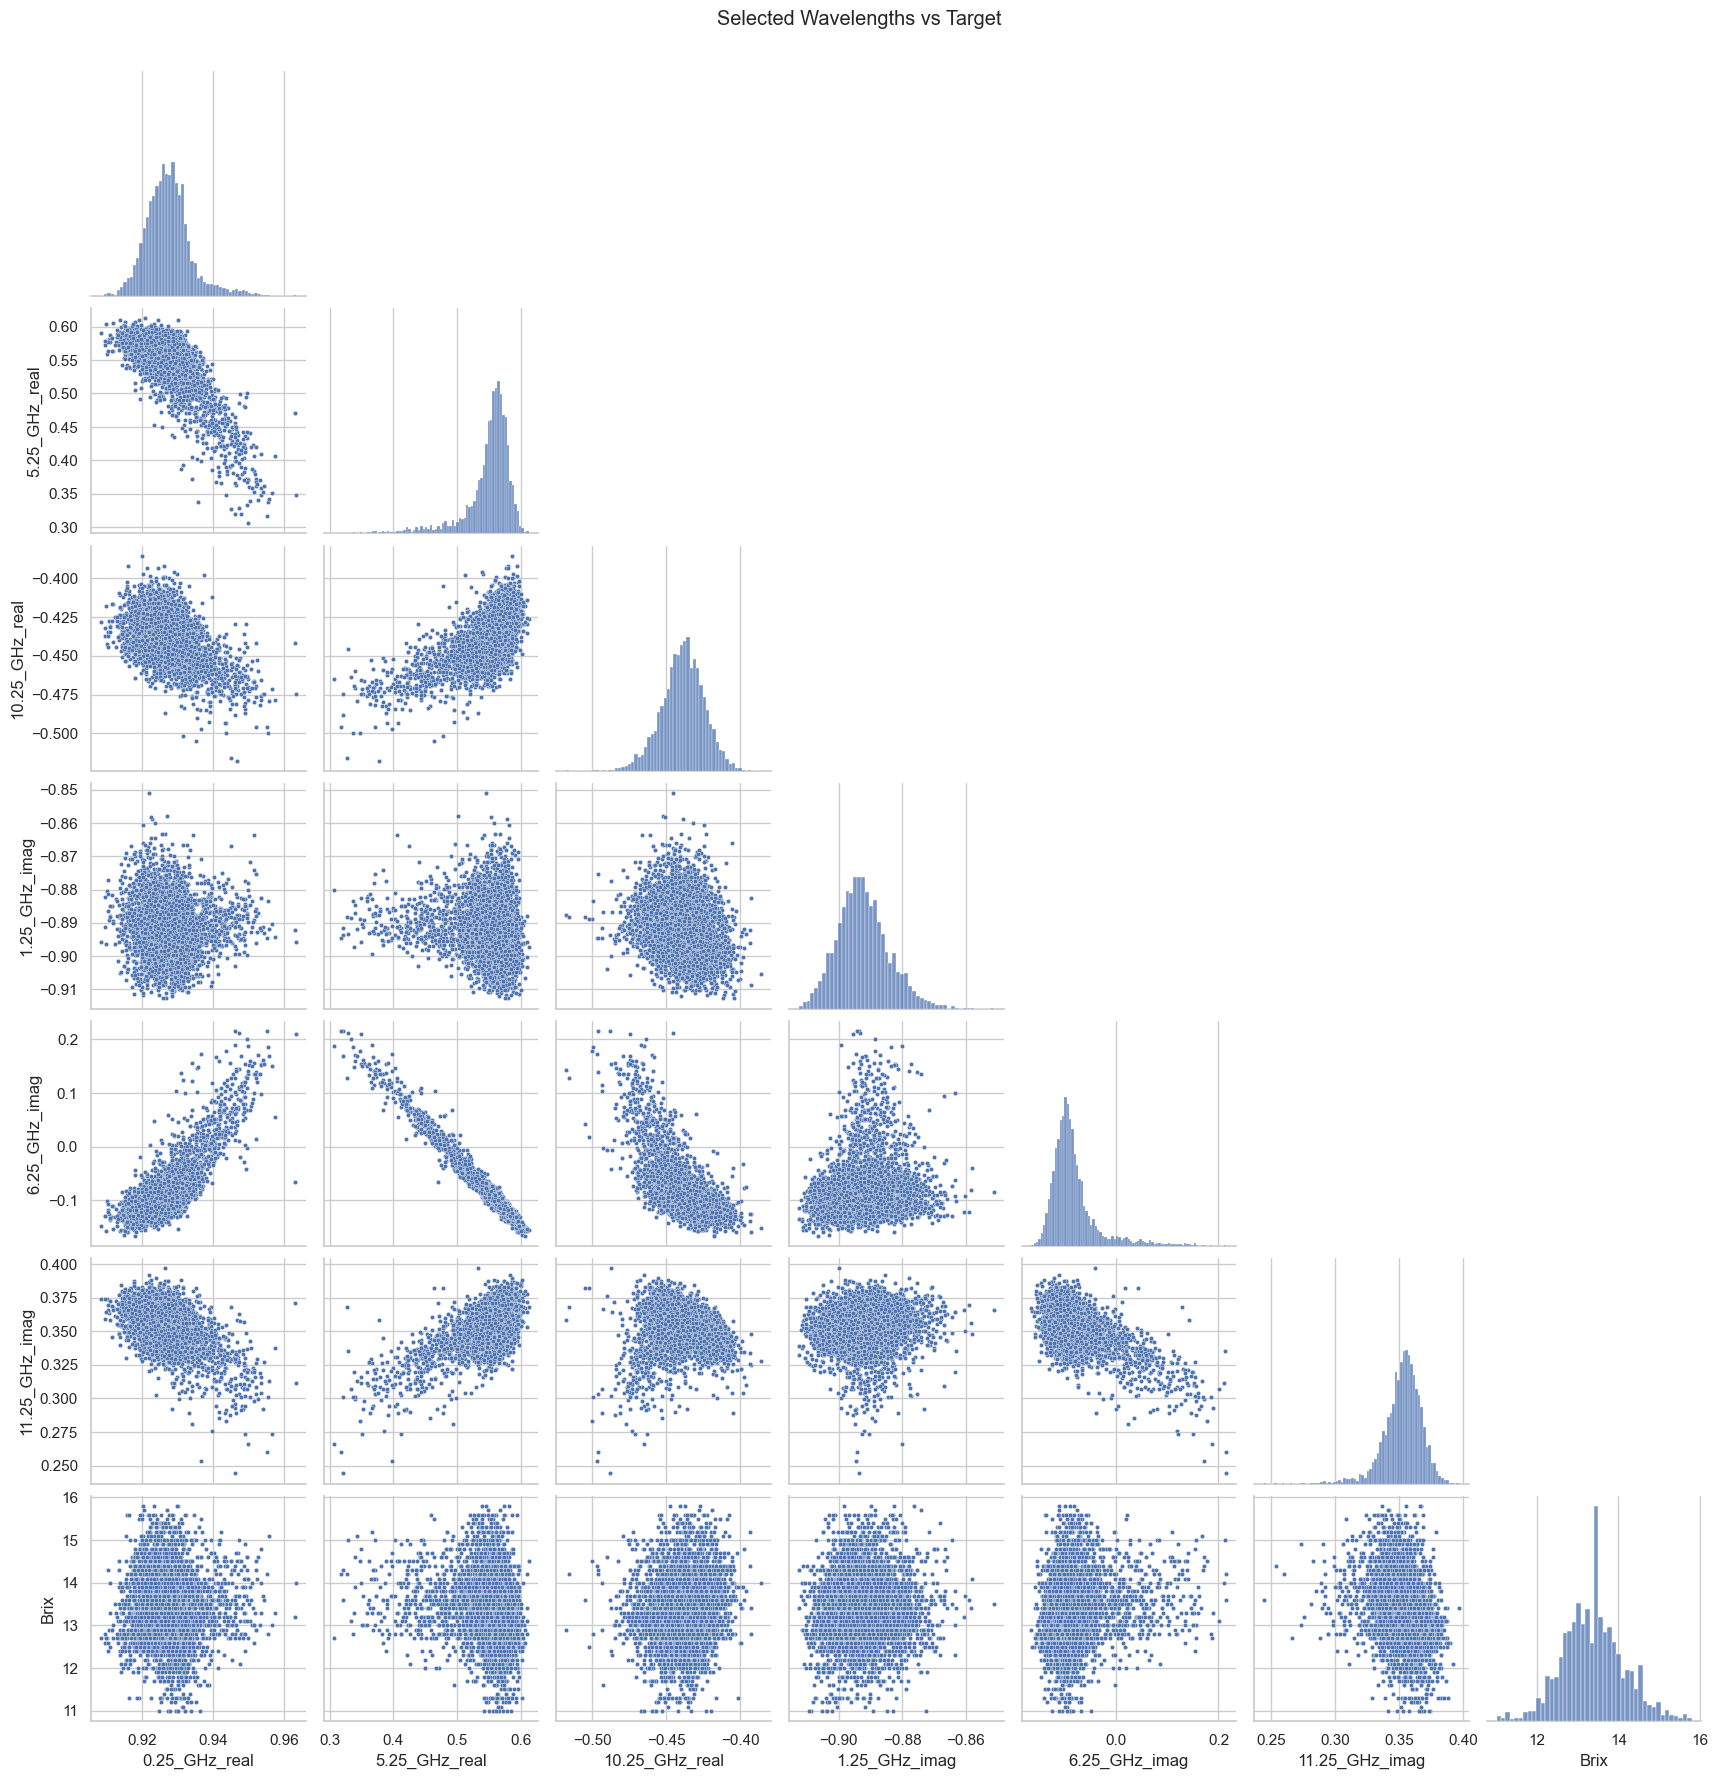

In [14]:
# pick every 20th spectral column
sample_feats = list(spec_cols[::20])
sns.pairplot(df_clean[sample_feats + [TARGET_COLUMN]], corner=True, plot_kws={"s":10})
plt.suptitle("Selected Wavelengths vs Target", y=1.02)
plt.show()


## Cell: t-SNE Visualization for All Targets (Brix, Firmness, TA)
Project spectra to 2D and color by each target variable to compare relationships.



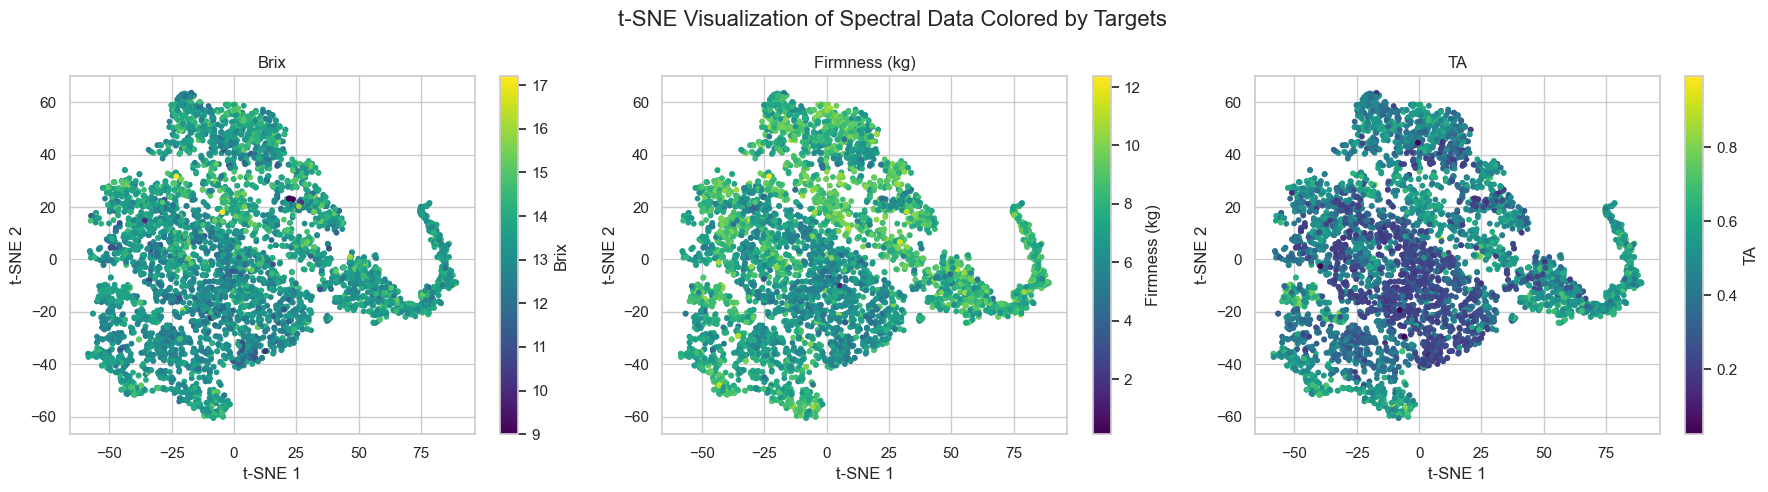

In [16]:
# Check that target columns exist
targets = ['Brix', 'Firmness (kg)', 'TA']  # Adjust names if needed
missing = [col for col in targets if col not in df.columns]
if missing:
    print(f"Missing columns in dataset: {missing}")
else:
    from sklearn.manifold import TSNE
    from sklearn.preprocessing import StandardScaler

    # Standardize the spectral features
    X = df[spec_cols].values
    X_scaled = StandardScaler().fit_transform(X)

    # Run t-SNE once (shared for all targets)
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)

    # Plot for each target
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for i, target in enumerate(targets):
        sc = axes[i].scatter(X_tsne[:, 0], X_tsne[:, 1],
                             c=df[target], cmap='viridis', s=10)
        axes[i].set_title(f'{target}')
        axes[i].set_xlabel('t-SNE 1')
        axes[i].set_ylabel('t-SNE 2')
        plt.colorbar(sc, ax=axes[i], label=target)

    fig.suptitle("t-SNE Visualization of Spectral Data Colored by Targets", fontsize=16)
    plt.tight_layout()
    plt.show()


## Cell: PCA Visualization of Spectral Data Colored by Targets
This shows how well each target variable aligns with the top 2 principal components of the spectra.


Explained variance ratio: [0.79527723 0.12448251]
Total variance captured: 0.92


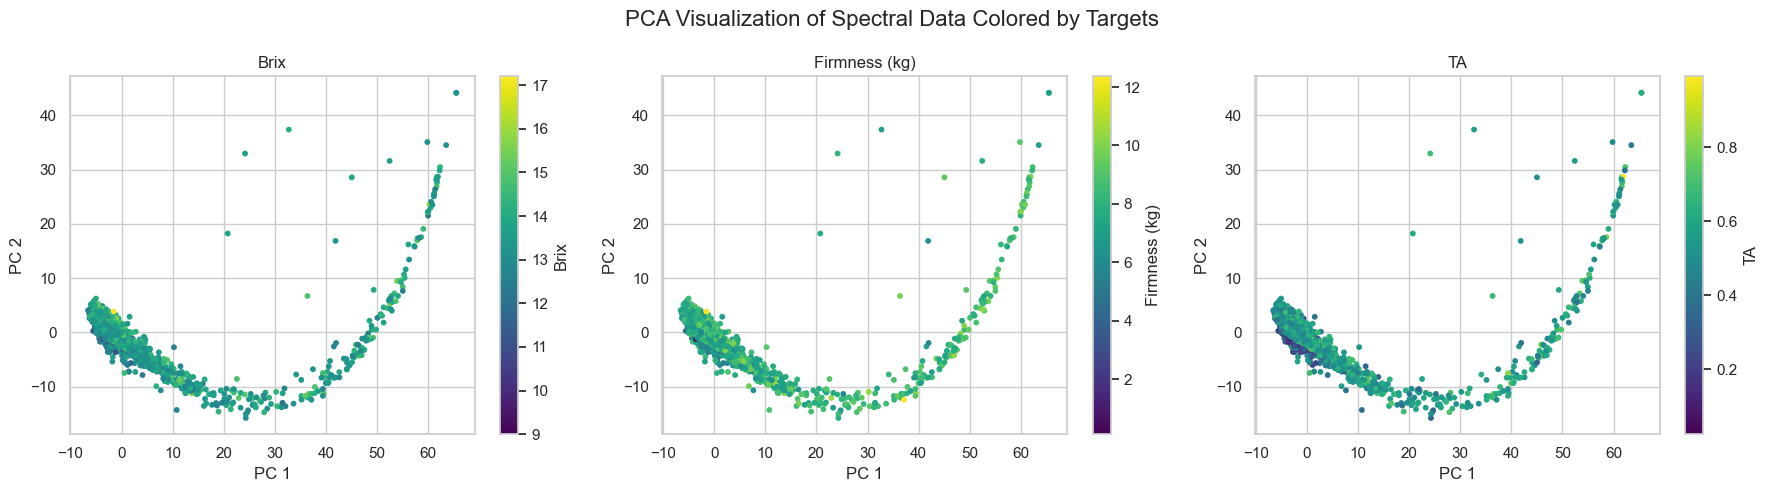

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Scale spectral features
X = df[spec_cols].values
X_scaled = StandardScaler().fit_transform(X)

# Run PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Explained variance
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance captured: {sum(pca.explained_variance_ratio_):.2f}")

# Plot each target
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, target in enumerate(targets):
    sc = axes[i].scatter(X_pca[:, 0], X_pca[:, 1],
                         c=df[target], cmap='viridis', s=10)
    axes[i].set_title(f'{target}')
    axes[i].set_xlabel('PC 1')
    axes[i].set_ylabel('PC 2')
    plt.colorbar(sc, ax=axes[i], label=target)

fig.suptitle("PCA Visualization of Spectral Data Colored by Targets", fontsize=16)
plt.tight_layout()
plt.show()
